_____
_____
## Описание

**Анализ данных интернет-магазина, который продает компьютерные игры**

- Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
- Цель исследования: yужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

_____
_____
## Импорт и подготовка к работе

In [1]:
# %pip install missingno==0.5.2
# %pip install numpy==1.26.4
# %pip install pandas==2.2.2
# %pip install plotly==5.24.0
# %pip install scipy==1.14.1

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', None)

_____
_____
## Загрузка данных и общая информация

_____
### Скачивание датасета

In [3]:
games = pd.read_csv('games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


_____
### Информация о датасете

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


|Поле             |Описание                                             |
|-----------------|-----------------------------------------------------|
|Name             |название игры                                        |
|Platform         |платформа                                            |
|Year_of_Release  |год выпуска                                          |
|Genre            |жанр игры                                            |
|NA_sales         |продажи в Северной Америке (миллионы проданных копий)|
|EU_sales         |продажи в Европе (миллионы проданных копий)          |
|JP_sales         |продажи в Японии (миллионы проданных копий)          |
|Other_sales      |продажи в других странах (миллионы проданных копий)  |
|Critic_Score     |оценка критиков (максимум 100)                       |
|User_Score       |оценка пользователей (максимум 10)                   |
|Rating           |возрастная категория                                 |

_____
### Вывод:

- Датасет содержит 16715 записей
- Колонки названы не корректно
- Фичи имеют разные типы данных, как числовые, так и категориальные
- В 6 из 11 столбцах есть пропуски

_____
_____
## Предобработка данных

_____
### Переименовывание столбцов датафрейма

In [5]:
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


_____
### Общая обработка датасета

- В колонке `year_of_release` есть значения "tbd", что рассшифровывается как "to be determined" (будет определено позже). Заменим эти значения на None

In [6]:
games.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [7]:
games.user_score= games.user_score.replace('tbd', None)
games.user_score = pd.to_numeric(games.user_score)

- Для удобства работы переведем диапазон `critic_score` с [0; 100] до [0; 10]

Это упростит сравнение значений между `user_score` и `critic_score`

In [8]:
games.critic_score = games.critic_score / 10 

- Создадим столбец с общими продажами

In [9]:
games['sales'] = games.na_sales + games.eu_sales + games.jp_sales

_____
### Обработка дубликатов

Дубликатами можно считать игры, названия, платформа и год выпуска которых совпадают. Это обусловлено тем что игра с одним названием может выйти на разных платформах и быть переиздана в разные года.

In [10]:
print('Было', games.shape[0])
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
print('Стало', games.shape[0])

Было 16715
Стало 16713


Ну пускай даже 2 строки.

_____
### Обработка пропушенных значений

#### Количество пропущенных в каждом столбце

,count missing,missing %
user_score,9124,54.592234
critic_score,8577,51.319332
rating,6765,40.477473
year_of_release,269,1.609526
name,1,0.005983
genre,1,0.005983
platform,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000


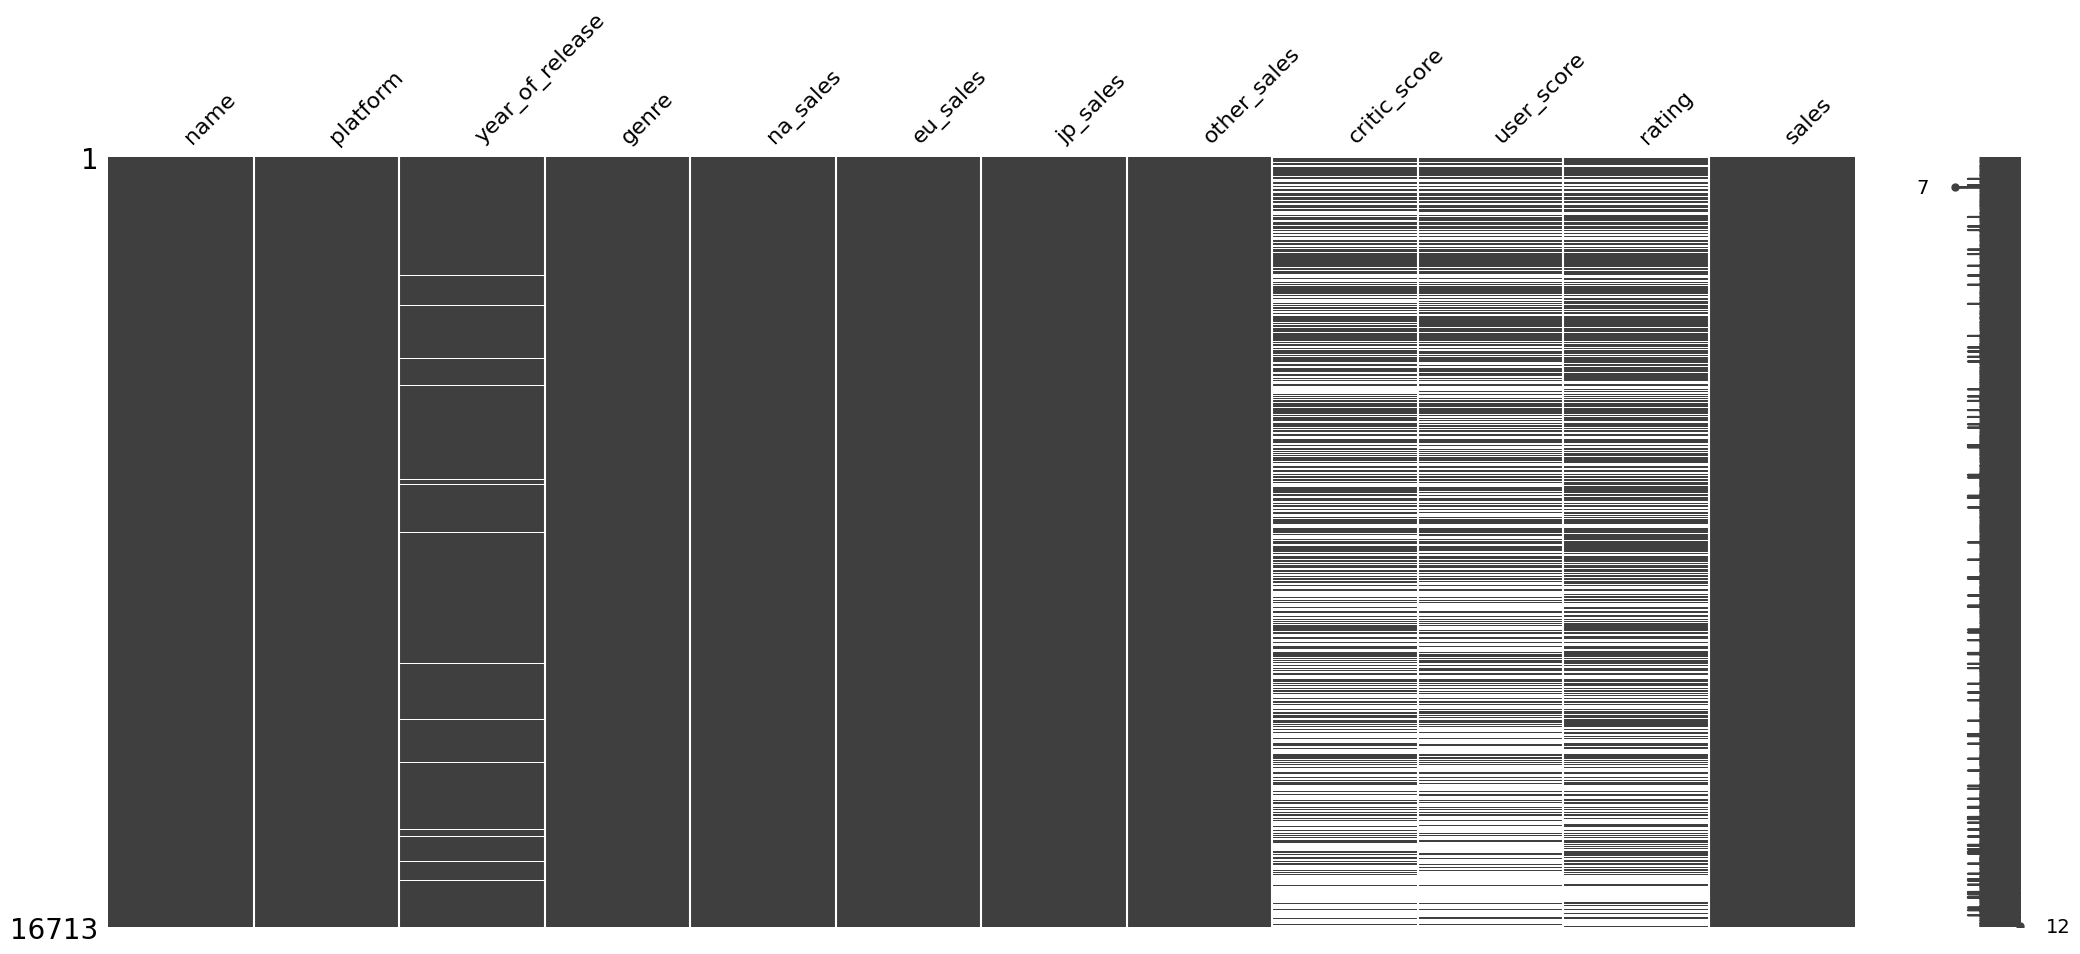

In [11]:
msno.matrix(games)

display(pd.DataFrame({
    'count missing': games.isna().sum().sort_values(ascending=False),
    'missing %': games.isna().mean().sort_values(ascending=False) * 100,
}).style.background_gradient('coolwarm'))

В датасете много пропусков, однако видно, что некоторую часть заполнить точно можно.

#### `year_of_release`, `genre`, `name`

Установим значение "Unknown" для пропусков в столбцах `name` и `genre` (их немного).

In [12]:
games.name = games.name.fillna('Unknown')
games.genre = games.genre.fillna('Unknown')

Для пропущенных значений в столбце `year_of_release` установим среднее значение `year_of_release` среди игр выпустившихся на платформе данной игры.

In [13]:
games.year_of_release = games.groupby('platform').year_of_release.transform(lambda x: x.fillna(x.mean()))

#### `critic_score`, `user_score`

По матрице пропущенных значений видно, что пропуски в этих столбцах чаще всего одновременно, однако есть "xor" пропуски.

In [14]:
print('Корреляция между user_score и critic_score равна', games.user_score.corr(games.critic_score))
px.scatter_matrix(
    games,
    dimensions=['user_score', 'critic_score'],
    opacity=0.2,
    height=400,
    width=400
)

Корреляция между user_score и critic_score равна 0.5811220781939388


Значение корреляции умеренное, будет вполне валидно заполним "xor" пропуски значениями "другого" столбца.

In [15]:
games.user_score = games.user_score.fillna(games.critic_score)
games.critic_score = games.critic_score.fillna(games.user_score)
games.critic_score.isna().sum()

8004

На этом закончим, потому что оставшихся пропущенных значений слишком много и заполнять медианной, средним будет невалидно.

_____
### Приведение типов данных

In [16]:
games.dtypes
games.year_of_release = games.year_of_release.astype('uint16')
display(games.dtypes)

name                object
platform            object
year_of_release     uint16
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
sales              float64
dtype: object

_____
### Обработка аномальных значений

In [17]:
fig = make_subplots(rows=3, cols=3, subplot_titles=games.select_dtypes(include=['number']).columns)

for i, column in enumerate(games.select_dtypes(include=['number']).columns):
    fig.add_trace(
        go.Box(y=games[column], name=column,),
        row=(i // 3) + 1, col=(i % 3) + 1
    )
fig.update_layout(height=1500, width=1200, showlegend=False)

Хоть математически в данных присутствуют выбросы, мы не будем их удалять, потому что все эти значения покажут истинную статистику. 

_____
### Вывод: 

<Axes: >

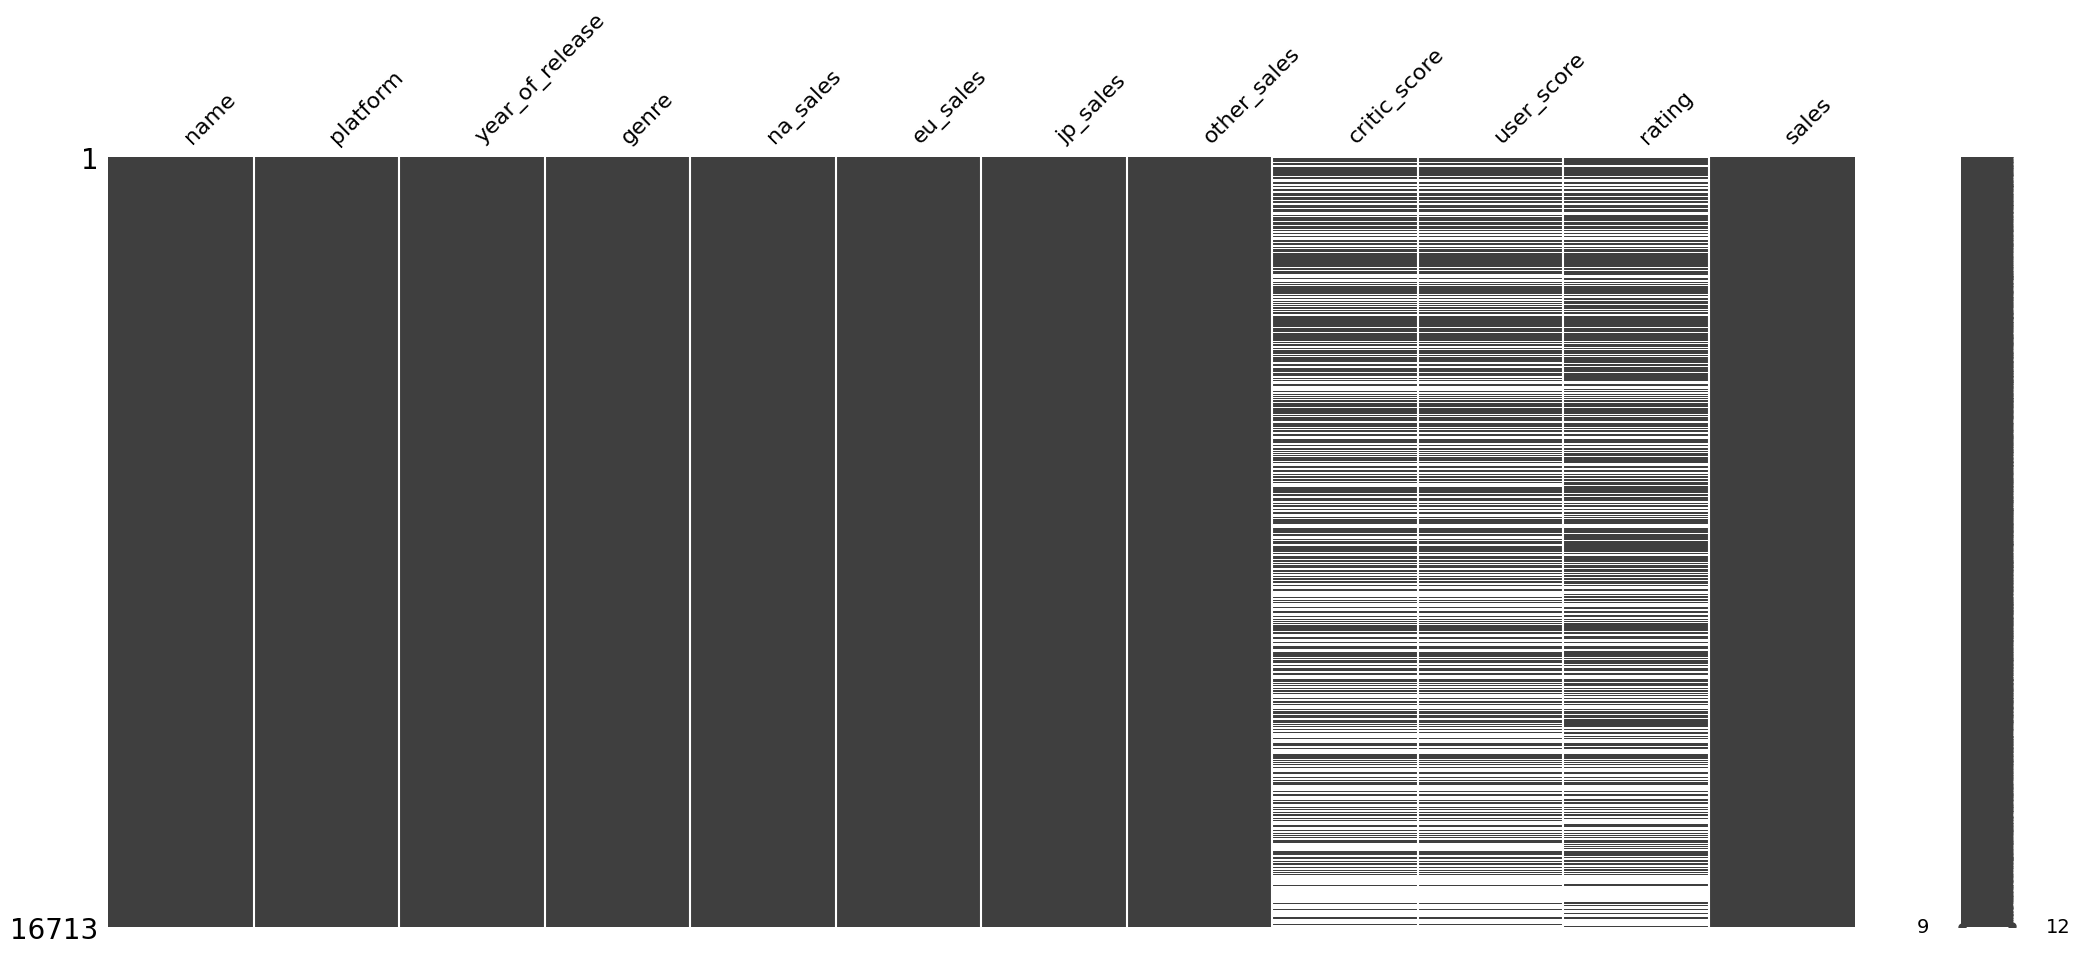

In [18]:
msno.matrix(games)

- Переимновал столбцы на корректные (таблица с колонками ниже)
- Создал новую колонку с общими продажами
- Нормировал `critic_score`
- Обработал пропущенные значения, но некоторые остались (матрица пропусков выше) 
- Привел колонки к корректным типам данных
- Аномальные значения не были выявлены

|Поле           |Тип данных|Описание                                             |
|---------------|----------|-----------------------------------------------------|
|name           |str       |Название игры                                        |
|platform       |str       |Платформа                                            |
|year_of_release|uint16    |Год выпуска                                          |
|genre          |str       |Жанр игры                                            |
|na_sales       |float     |Продажи в Северной Америке (миллионы проданных копий)|
|eu_sales       |float     |Продажи в Европе (миллионы проданных копий)          |
|jp_sales       |float     |Продажи в Японии (миллионы проданных копий)          |
|other_sales    |float     |Продажи в других странах (миллионы проданных копий)  |
|critic_score   |float     |Оценка критиков (максимум 100)                       |
|user_score     |float     |Оценка пользователей (максимум 10)                   |
|rating         |str       |Возрастная категория                                 |
|sales          |float     |Продажи во всем мире (миллионы проданных копий)      |

_____
_____
## Исследовательский анализ данных

_____
#### Функции отрисовки статистических графиков

In [19]:
def barh(series, title, xaxis_title='Продажи'):
	go.Figure(go.Bar(
		x=series.values,
		y=series.index,
		orientation='h',
		textposition='outside',
		text=series.values.round(1),
	)).update_layout(
		title=title,
		xaxis_title=xaxis_title,
		yaxis_title=series.name,
		height=800,
		width=1200
	).show()


def feature_sales_dist_through_years(feature_values, feature_sales_dist, title_text):
	fig = go.Figure()
	for feature_value in feature_values:
		fig.add_trace(
			go.Scatter(
				x=feature_sales_dist[feature_value].index,
				y=feature_sales_dist[feature_value],
				marker=dict(symbol='circle'),
				name=feature_value,
			)
		)
	fig.update_xaxes(title_text='year')
	fig.update_yaxes(title_text='sales')

	fig.update_layout(
		title_text=title_text,
		width=800,
		height=500,
		showlegend=True,
	)
	fig.show()


def statistical_graphis_for_categorical(col: pd.Series):
	category_counts = col.value_counts()
	categories = category_counts.index
	counts = category_counts.values

	fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'xy'}, {'type': 'domain'}]],
		subplot_titles=(f'Гистограмма {col.name}', f'Круговая диаграмма {col.name}'))

	fig.add_trace(
		go.Histogram(x=col, marker_color='green', showlegend=False, name=''),
		row=1, col=1
	)
	fig.update_xaxes(title_text=col.name, categoryorder='total ascending', row=1, col=1)
	fig.update_yaxes(title_text='Частота', row=1, col=1)

	fig.add_trace(
		go.Pie(labels=categories, values=counts, name='', textinfo='none'),
		row=1, col=2
	)

	fig.update_layout(
		title_text=f'Статистический анализ для {col.name}',
		showlegend=True,
		width=1000,
		height=500,
	)

	fig.show()


def box_sales(games, feature_name, range_cropped=None, only_first=None, height=1000, width=1000):
	fig = go.Figure()
	if not only_first:
		only_first = len(games[feature_name].unique())
	for feature_val in games[feature_name].unique():
		fig.add_trace(go.Box(
			y=games.query(f'{feature_name} == @feature_val').sales,
			name=feature_val,
			visible=bool(only_first) if only_first else 'legendonly' 
		))
		if only_first:
			only_first -= 1

	fig.update_yaxes(
		title_text='sales'
	).update_layout(
		title_text=f'Диаграмма размаха sales по каждому значению {feature_name}',
		height=height,
		width=width,
		
		# Нашел в инете
		updatemenus=[{
			'buttons': [{'args': [{'yaxis.autorange': True}],
						 'label': 'Полный',
						 'method': 'relayout'},
						{'args': [{'yaxis.range': range_cropped}],
						'label': 'Обрезанный',
						'method': 'relayout'},
						],
			'direction': 'down',
			'showactive': True,
			'x': 1.02,
			'y': 1.05,
			'xanchor': 'left',
			'yanchor': 'top'
		}] if range_cropped else None
	).show()

_____
#### Количество игр, выпущенных в разные годы.

In [20]:
statistical_graphis_for_categorical(games.year_of_release.sort_values())

Все года в итоговой выборке не будут полезны, потому что игры меняются, меняются уровень продаж, поэтому старые игры станут статистических "баластом".

_____
### Продажи каждой платформы.

In [21]:
platform_sales = games.groupby('platform').sales.sum().sort_values()
barh(platform_sales, title='Продажи игр на платформах')

Выберем топ 7 самых популярных платформ

In [22]:
pop_platform = platform_sales.tail(7).index
pop_platform_dist_years = games.query('platform in @ pop_platform').groupby(by=['platform', 'year_of_release']).sales.sum()
feature_sales_dist_through_years(pop_platform, pop_platform_dist_years, title_text='Распределение продаж игр по годам для популярных платформ')

- Каждые платформа имеет хорошую статистику в среднем 5 лет. Так как мы планируем компанию на 2017 год, то далее будем рассматривать временной промежуток с 2011 до 2016.

- Стоит отметить что каждая консоль имеет сперва высходящий, а потом нисходящий тренд по двум факторам: 
	- Консоль набирает популярность, ее покупают, а потом продажи консолей уменьшается из-за того, что большиство желающих купили и консоль впринципе со временем становится неактуальной
	- Аналогично с играми

- То что продажи игр к 2016 всех актуальных консолей падают, не означает что игры теряют популярность, а то что не все игроки успели купить вышедшие за последние годы игры. 

_____
### Актуальный период для прогноза на 2017 год.

In [23]:
games = games.query('year_of_release > 2010')
games.shape

(4030, 12)

Посмотрим сколько игр получилось на каждой платформе.

In [24]:
games.platform.value_counts()

platform
PS3     707
3DS     520
X360    498
PSV     430
PS4     392
PC      389
PSP     312
XOne    247
Wii     197
DS      184
WiiU    147
PS2       7
Name: count, dtype: int64

у платформа PS2 из-за фильтрации по `year_of_release` осталось всего 7 игр, что делает эту плафторму невалидной для анализа.

In [25]:
games = games.query('platform != "PS2"')

In [26]:
platform_sales_actual_years = games.groupby('platform').sales.sum().sort_values()
barh(platform_sales_actual_years, title='Продажи игр на платформах за акутальный период')

- Лидерами продаж за период 2011-2016 являются PS3, X360, PS4 и 3DS

In [27]:
pop_platform_actual_years = platform_sales_actual_years.tail(7).index
pop_platform_dist_actual_years = games.query('platform in @ pop_platform_actual_years').groupby(by=['platform', 'year_of_release']).sales.sum()
feature_sales_dist_through_years(pop_platform_actual_years, pop_platform_dist_actual_years, title_text='Распределение продаж игр по актуальным годам для популярных платформ',)

- Ведущие позиции на рынке держат такие платформы как: PS4 и XOne. Это самые новые консоли, соотвественно игровая индустрия нацелена на релиз на этих платформах.
- Остальные консоли старые, однако также держат уровень популярности.
- Как видно на примере новых консолей, с их покупкой пользователи покупают игры, а через какое-то время после релиза, потребности в этом становится меньше, потому что игры на платформы выпускаются не так часто.
- А старые платформы имеют нисходящий тренд, наверное из-за того, что они не могут поддерживать новые игры.

_____
### Диаграмма размаха sales по каждой платформе

In [28]:
box_sales(games, 'platform', only_first=5, range_cropped=[0, 0.75])

Справа от графика есть легенды, нажав на них можно добавить/убрать диаграммы размаха каждой платформы, это помогает более детально сравнивать их. Также там расположена кнопка сохращий диапазон рассматриваемых значений sales.

- Каждая диаграмма показывает уникальные статистические характеристики, отражая свою популярность и успех на рынке.
- Также практически каждый бокс имеет выбросы, однако удалять их является ошибкой, потому что эти выбросы отражают очень удачные продажи игры на платформе, что имеет большую статистическую значимость.

_____
### Влияние отзывов пользователей и критиков на продажи игр относительно каждой платформы

In [29]:
platforms = games.platform.unique()
fig = make_subplots(rows=len(platforms), cols=2,
					subplot_titles=np.array([[platform, platform] for platform in platforms]).flatten())
row = 1

for platform in platforms:
	platform_games = games.query('platform == @platform').dropna(subset=['user_score', 'sales'])
		
	fig.add_trace(go.Scatter(x=platform_games.critic_score,
							 y=platform_games.sales,
							 mode='markers',
							 marker=dict(size=7, opacity=0.3),
							 name=''),
				  row=row, col=1)
	slope, intercept = np.polyfit(platform_games.critic_score, platform_games.sales, 1)
	regression_line = slope * platform_games.critic_score + intercept
	fig.add_trace(go.Scatter(x=platform_games.critic_score,
							 y=regression_line,
							 mode='lines',
							 line=dict(color='black'),
							 name=''),
				  row=row, col=1)
	fig.update_xaxes(title_text='critic_score', row=row, col=1).update_yaxes(title_text='sales', row=row, col=1)
	fig['layout']['annotations'][(row-1)*2]['text'] += f' (corr = {slope:.3f}))'

	fig.add_trace(go.Scatter(x=platform_games.user_score,
							 y=platform_games.sales,
							 mode='markers',
							 marker=dict(size=7, opacity=0.3),
							 name=''),
				  row=row, col=2)
	slope, intercept = np.polyfit(platform_games.user_score, platform_games.sales, 1)
	regression_line = slope * platform_games.user_score + intercept
	fig.add_trace(go.Scatter(x=platform_games.user_score,
							 y=regression_line,
							 mode='lines',
							 line=dict(color='black'),
							 name=''),
				  row=row, col=2)
	fig.update_xaxes(title_text='user_score', row=row, col=2).update_yaxes(title_text='sales', row=row, col=2)
	fig['layout']['annotations'][(row-1)*2+1]['text'] += f' (corr = {slope:.3f}))'
		
	row += 1

fig.update_layout(
	title_text='Диаграммы рассеивания для определения зависимости sales от critic_score и user_score',
	width=1000,
	height=6000,
	showlegend=False,
)
fig.show()

- Корреляция взависимости от платформы и оценок (critic/user) сильно варьируется.
- `critic_score` на актуальных платформах показывает положительные умеренные корреляции, это указавает на то, что высокие оценки критиков увеличивают продажи и наоборот. Но есть и слабые значения корреляции, преимущественно на неактуальных платформах, что говорит о том, что мнение критиков имеют значимость только на популярных консолях.
- Корреляция между `user_score` и `sales` по каждой платформе значительно меньше, где-то даже отрицительная, кроме платформы WiiU (она там умеренная). Вообщем зависимость слабая.

_____
### Общее распределение игр по жанрам

In [30]:
statistical_graphis_for_categorical(games.genre)

Больше всего игр жанра Action, Role-Playing, Adventure

In [31]:
genre_sales = games.groupby('genre').sales.sum().sort_values()
pop_genre_dist_years = games.query('genre in @games.genre.unique()').groupby(by=['genre', 'year_of_release']).sales.sum()
feature_sales_dist_through_years(games.genre.unique(), pop_genre_dist_years, f'Распределение продаж игр по годам по каждому жанру')

Игры жанра Shooter и Sports имееют высходящий тренд последние годы, а ранее самый популярный Action, нисходящий. Также можно заметить в 2016 году Shooter обогнали Action.

In [32]:
box_sales(games, 'genre', range_cropped=[0, 1.2], width=1200, only_first=6)

- Хоть самый большой разброс значений `sales` у жанра Action, в среднем самым прибыльным является жанр Shooter
- Менее прибыльными можно считать жанры медиана которых меньше 0.5 (Adventure и Puzzle)

_____
### Вывод

- Однако старые игры (до 2010 года) могут искажать современную картину, поскольку тенденции и уровень продаж меняются со временем.
- Лидерами по продажам игр являются такие платформы, как PS3, X360, PS4 и 3DS.
- Каждая платформа имеет "жизненный цикл", который длится примерно 5 лет, где наблюдается сначала рост, а затем спад продаж.
- В 2016 году на рынке преобладают новые консоли, такие как PS4 и XOne.
- Выбросы не следует удалять, так как они статистически самые важные объекты.
- Зависимость продаж игр от оценок критиков на популярных платформах (PS4, XOne) умеренно положительная. На менее актуальных консолях эта связь либо слабая.
- Оценки пользователей (user_score) слабо коррелируют с продажами на большинстве платформ.
- Жанры с высокими продажами, такие как Action и Shooter занимают большую долю рынка.